# Choosing where to live when remote employment is an option
##### Coursera Applied Data Science Capstone: _Battle of the Neighborhoods_

## Introduction
The COVID-19 pandemic normalized remote employment and made it possible for many workers to live almost anywhere without having to separate from their current employer. This project uses structured, agglomerative clustering to compare neighborhoods in two cities, Toronto and Philadelphia, using data from Foursquare. Neighborhoods from each city are associated with similar neighborhoods in the other city. Neighborhoods that are relatively dissimilar from neighborhoods in the other city are also identified. By characterizing the neighborhoods of each city relative to the other, someone familiar with only one city's neighborhoods (e.g., a current resident) could make a better decision about where in the other city to live. Though this project is limited to just two cities, the scope could be broadened to an arbitrary number of locales. Results are summarized geospatially and a brief qualitative review of Foursquare data by groups of neighborhoods is discussed.

## Data
Toronto and Philadelphia have 103 and 48 postal codes, respectively. These postal codes serve as proxies for each city's neighborhoods. Github user _AG2816_ posted a geoJSON file containing Toronto's postal codes, available [here](https://github.com/ag2816/Visualizations/raw/master/data/Toronto2.geojson). The organization [OpenDataPhilly.org](https://opendataphilly.org) provides geoJSON files for Philadelphia postal codes, available [here](http://data.phl.opendata.arcgis.com/datasets/b54ec5210cee41c3a884c9086f7af1be_0.geojson). The boundary points for each postal code in each city are useful for creating qualitative choropleth maps using geopandas.

When presenting results, I replaced the postal codes with neighborhood names. For Toronto, I scraped neighborhood names from [this](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) Wikipedia page. For Philadelphia, I compiled neighborhood names from pages 18 and 19 of [this](https://www.pewtrusts.org/en/research-and-analysis/reports/2014/07/09/homeownership-in-philadelphia-on-the-decline) _Pew Charitable Trusts_ report. 

To compare neighborhoods in the two cities, I used data from [Foursquare](http://www.foursquare.com). I did not consider additional neighborhood data (e.g., housing prices, crime, access to public transportation, etc.), though it would be possible to expand the analysis to include an arbitrary number of features.

Copies of all data used in this analysis are available [here](https://github.com/JaeAre/Coursera_Capstone.git), including the results retrieved from Foursquare.

### Retrieve postal code geoJSON files
The Toronto postal code file contains only residential postal codes, per the the explanation on the author's Github. The Philadelphia postal code file contains two postal codes, 19109 and 19112, not included by _Pew Charitable Trusts_ in their report on housing trends in Philadelphia. These two postal codes are non-residential. The former is an area with a radius of less than 100 yards sometimes referred to as the _Market Street Department Store District_. The latter is the _Philadelphia Navy Yard_. Both of these non-residential postal codes will be dropped from further analysis.

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import geopandas as gpd # library for geospatial data analysis

In [2]:
# Read Toronto postal code geoJSON data into geopandas dataframe 
url = "https://github.com/ag2816/Visualizations/raw/master/data/Toronto2.geojson"
toronto_bounds = gpd.read_file(url)
toronto_bounds.dtypes # looks good

CFSAUID       object
PRUID         object
PRNAME        object
geometry    geometry
dtype: object

In [3]:
# Read Philadelphia postal code geoJSON data into geopandas dataframe 
url = "http://data.phl.opendata.arcgis.com/datasets/b54ec5210cee41c3a884c9086f7af1be_0.geojson"
philly_bounds = gpd.read_file(url)
philly_bounds.dtypes # looks good

OBJECTID            int64
CODE               object
COD                 int64
Shape__Area       float64
Shape__Length     float64
geometry         geometry
dtype: object

In [4]:
# A quick look at these two dataframes suggests we can clean them up a bit
display(toronto_bounds.head())
display(philly_bounds.head())

,CFSAUID,PRUID,PRNAME,geometry
0,M9R,35,Ontario,"MULTIPOLYGON (((-79.56131 43.67478, -79.56249 ..."
1,M9V,35,Ontario,"MULTIPOLYGON (((-79.57759 43.76205, -79.57829 ..."
2,M9W,35,Ontario,"MULTIPOLYGON (((-79.53885 43.72937, -79.53884 ..."
3,M1P,35,Ontario,"MULTIPOLYGON (((-79.24704 43.75374, -79.24720 ..."
4,M1R,35,Ontario,"MULTIPOLYGON (((-79.28125 43.73867, -79.27985 ..."


,OBJECTID,CODE,COD,Shape__Area,Shape__Length,geometry
0,1,19120,20,9.177970e+07,49921.544063,"POLYGON ((-75.11107 40.04682, -75.10943 40.045..."
1,2,19121,21,6.959879e+07,39534.887217,"POLYGON ((-75.19227 39.99463, -75.19205 39.994..."
2,3,19122,22,3.591632e+07,24124.645221,"POLYGON ((-75.15406 39.98601, -75.15328 39.985..."
3,4,19123,23,3.585175e+07,26421.728982,"POLYGON ((-75.15190 39.97056, -75.15150 39.970..."
4,5,19124,24,1.448080e+08,63658.770420,"POLYGON ((-75.09660 40.04249, -75.09281 40.039..."


In [5]:
# Drop some columns and rename others for consistency across the two cities.
toronto_bounds.rename(columns={"CFSAUID":"CODE"}, inplace=True)
toronto_bounds.drop(columns=["PRUID","PRNAME"], inplace = True)
philly_bounds['CODE'] = philly_bounds['CODE'].astype(str) # make sure it's a string
philly_bounds.drop(columns=["OBJECTID","Shape__Area","Shape__Length","COD"], inplace = True)
philly_bounds = philly_bounds[~philly_bounds.CODE.isin(['19109','19112'])]

In [6]:
display(philly_bounds.head())
display(toronto_bounds.head()) # looks good!

,CODE,geometry
0,19120,"POLYGON ((-75.11107 40.04682, -75.10943 40.045..."
1,19121,"POLYGON ((-75.19227 39.99463, -75.19205 39.994..."
2,19122,"POLYGON ((-75.15406 39.98601, -75.15328 39.985..."
3,19123,"POLYGON ((-75.15190 39.97056, -75.15150 39.970..."
4,19124,"POLYGON ((-75.09660 40.04249, -75.09281 40.039..."


,CODE,geometry
0,M9R,"MULTIPOLYGON (((-79.56131 43.67478, -79.56249 ..."
1,M9V,"MULTIPOLYGON (((-79.57759 43.76205, -79.57829 ..."
2,M9W,"MULTIPOLYGON (((-79.53885 43.72937, -79.53884 ..."
3,M1P,"MULTIPOLYGON (((-79.24704 43.75374, -79.24720 ..."
4,M1R,"MULTIPOLYGON (((-79.28125 43.73867, -79.27985 ..."


### Get the centroid for each postal code
The function _get_postal_code_centroid_ uses the _pgeocode_ library to query the centroid of supplied postal codes. It is possible to calculate the centroids from the postal code geometries. However, if only the postal codes are available (often the case), this function is useful. It has three parameters.

* __country_code__: the two digit country code. We will use 'us' for Philadelphia and 'ca' for Toronto.
* __df__: pandas dataframe containing postal codes in one of its columns.
* __postal_code_column__: the name of the column in _df_ containing the postal codes.

The function writes the centroid of each postal code to the dataframe _df_ as _Centroid Latitude_ and _Centroid Longitude_. 

In [7]:
def get_postal_code_centroid(country_code, df, postal_code_column):
    geolocator = pgc.Nominatim(country_code)
    postal_code_centroid_latitude, postal_code_centroid_longitude = ([] for i in range(2))
    for pc in df[postal_code_column]:
        postal_code_centroid_latitude.append(geolocator.query_postal_code(pc).latitude)
        postal_code_centroid_longitude.append(geolocator.query_postal_code(pc).longitude)
    df[['Centroid_Latitude','Centroid_Longitude']] = pd.DataFrame({'Latitude': postal_code_centroid_latitude, 'Longitude': postal_code_centroid_longitude}, index=df.index)

In [8]:
import pgeocode as pgc
get_postal_code_centroid('us', philly_bounds, 'CODE') # get the centroid of each Philadelphia postal code.
get_postal_code_centroid('ca', toronto_bounds, 'CODE') # get the centroid of each Toronto postal code.

display(philly_bounds.head())
display(toronto_bounds.head()) # looks good!

,CODE,geometry,Centroid_Latitude,Centroid_Longitude
0,19120,"POLYGON ((-75.11107 40.04682, -75.10943 40.045...",40.0343,-75.1213
1,19121,"POLYGON ((-75.19227 39.99463, -75.19205 39.994...",39.9811,-75.1740
2,19122,"POLYGON ((-75.15406 39.98601, -75.15328 39.985...",39.9780,-75.1459
3,19123,"POLYGON ((-75.15190 39.97056, -75.15150 39.970...",39.9660,-75.1510
4,19124,"POLYGON ((-75.09660 40.04249, -75.09281 40.039...",40.0178,-75.0895


,CODE,geometry,Centroid_Latitude,Centroid_Longitude
0,M9R,"MULTIPOLYGON (((-79.56131 43.67478, -79.56249 ...",43.6898,-79.5582
1,M9V,"MULTIPOLYGON (((-79.57759 43.76205, -79.57829 ...",43.7432,-79.5876
2,M9W,"MULTIPOLYGON (((-79.53885 43.72937, -79.53884 ...",43.7144,-79.5909
3,M1P,"MULTIPOLYGON (((-79.24704 43.75374, -79.24720 ...",43.7612,-79.2707
4,M1R,"MULTIPOLYGON (((-79.28125 43.73867, -79.27985 ...",43.7507,-79.3003


### Retrieve Foursquare data
The two code blocks where _toronto_venues_ and _philly_venues_ are defined using Foursquare are commented out. There are two reasons for this. First, it avoids requerying the Foursquare API, which I have learned sometimes gives an error depending on the time of day it is run. Second, the results change each time the data are queried. Any discussion presented later may make no sense if the data change.

I provide a permanent link to the data I retrieved from Foursquare. Those data are used going forward. The client secret that appears in the next block is obsolete.

In [9]:
CLIENT_ID = 'XJMBXM0AODORTWPZAAMRGHBBQEE2S5TW045A4EGX1JSTOCD2' # your Foursquare ID
CLIENT_SECRET = '2UXGVV2EIFW12WDQSE3YFNUB41GA15SALIGRPJRYWVPS0NG1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

import requests

Your credentails:
CLIENT_ID: XJMBXM0AODORTWPZAAMRGHBBQEE2S5TW045A4EGX1JSTOCD2
CLIENT_SECRET:2UXGVV2EIFW12WDQSE3YFNUB41GA15SALIGRPJRYWVPS0NG1


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['CODE', 
                  'CODE Latitude', 
                  'CODE Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
#philly_venues = getNearbyVenues(names = philly_bounds['CODE'],
#                                latitudes = philly_bounds['Centroid_Latitude'],
#                                longitudes = philly_bounds['Centroid_Longitude'])
#philly_venues.to_csv('Philadelphia Foursquare Venues Complete 20210102.csv')

In [12]:
#toronto_venues = getNearbyVenues(names = toronto_bounds['CODE'],
#                                latitudes = toronto_bounds['Centroid_Latitude'],
#                                longitudes = toronto_bounds['Centroid_Longitude'])
#toronto_venues.to_csv('Toronto Foursquare Venues Complete 20210102.csv')

In [13]:
# Read static copy of Foursquare results.
philly_venues =  pd.read_csv("https://github.com/JaeAre/Coursera_Capstone/raw/main/Philadelphia%20Foursquare%20Venues%20Complete%2020210101.csv", index_col=0)
toronto_venues = pd.read_csv("https://github.com/JaeAre/Coursera_Capstone/raw/main/Toronto%20Foursquare%20Venues%20Complete%2020210101.csv", index_col=0)

# Some quick summary of the data from Foursquare.
tor = toronto_venues.shape[0]
phl = philly_venues.shape[0]
print("There were {} venues returned for Toronto and {} venues returned for Philadelphia.".format(tor,phl))
tor = len(toronto_venues['Venue Category'].unique())
phl = len(philly_venues['Venue Category'].unique())
print('There are {} unique categories for Toronto and {} unique categories for Philadelphia.'.format(tor, phl))

There were 1725 venues returned for Toronto and 1144 venues returned for Philadelphia.
There are 260 unique categories for Toronto and 215 unique categories for Philadelphia.


### Prepare the data for analysis
Creating files with multiple indices will be helpful for combining analysis results with the geospatial information on each postal code.

In [32]:
# create a single dataframe with multiIndex City and CODE keys for the Foursquare data.
philly_venues.set_index(philly_venues['CODE'], inplace=True)
toronto_venues.set_index(toronto_venues['CODE'], inplace=True)
all_venues = pd.concat([philly_venues, toronto_venues], keys = ['Philadelphia', 'Toronto'])
all_venues = all_venues.rename_axis(['City','CODE'])

# one hot encoding
all_venues_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# let's group the rows by neighborhood and taking the mean of the frequncy of occurrence of each category
all_venues_grouped = all_venues_onehot.groupby(level=[0,1]).mean()

# Take a look at the results
display(all_venues_grouped)

ATM  Accessories Store  Adult Boutique  \
City         CODE                                                 
Philadelphia 19102  0.000000           0.010000        0.000000   
             19103  0.000000           0.000000        0.000000   
             19104  0.000000           0.000000        0.000000   
             19106  0.000000           0.000000        0.010417   
             19107  0.000000           0.000000        0.000000   
             19111  0.000000           0.000000        0.000000   
             19114  0.000000           0.000000        0.000000   
             19115  0.000000           0.000000        0.000000   
             19116  0.000000           0.000000        0.000000   
             19118  0.000000           0.000000        0.000000   
             19119  0.000000           0.000000        0.000000   
             19120  0.000000           0.000000        0.000000   
             19121  0.000000           0.000000        0.000000   
             19122  0.000000           0.000000        0.000000   
             19123  0.000000           0.000000        0.000000   
             19124  0.000000           0.000000        0.000000   
             19125  0.000000           0.000000        0.000000   
             19126  0.000000           0.000000        0.000000   
             19127  0.000000           0.000000        0.000000   
             19128  0.000000           0.000000        0.000000   
             19129  0.000000           0.000000        0.000000   
             19130  0.000000           0.000000        0.000000   
             19131  0.000000           0.000000        0.000000   
             19132  0.000000           0.000000        0.000000   
             19133  0.000000           0.000000        0.000000   
             19134  0.000000           0.000000        0.000000   
             19135  0.000000           0.000000        0.000000   
             19136  0.000000           0.000000        0.000000   
             19137  0.000000           0.000000        0.000000   
             19138  0.000000           0.000000        0.000000   
             19139  0.000000           0.000000        0.000000   
             19140  0.000000           0.000000        0.000000   
             19141  0.000000           0.000000        0.000000   
             19142  0.142857           0.000000        0.000000   
             19143  0.000000           0.000000        0.000000   
             19144  0.000000           0.000000        0.000000   
             19145  0.000000           0.000000        0.000000   
             19146  0.000000           0.000000        0.000000   
             19147  0.000000           0.000000        0.000000   
             19148  0.000000           0.000000        0.000000   
             19149  0.000000           0.000000        0.000000   
             19150  0.000000           0.000000        0.000000   
             19151  0.000000           0.000000        0.000000   
             19152  0.000000           0.000000        0.000000   
             19153  0.000000           0.000000        0.000000   
             19154  0.000000           0.000000        0.000000   
Toronto      M1B    0.000000           0.000000        0.000000   
             M1C    0.000000           0.000000        0.000000   
             M1E    0.000000           0.000000        0.000000   
             M1G    0.000000           0.000000        0.000000   
             M1H    0.000000           0.000000        0.000000   
             M1J    0.000000           0.000000        0.000000   
             M1K    0.000000           0.000000        0.000000   
             M1L    0.000000           0.000000        0.000000   
             M1M    0.000000           0.000000        0.000000   
             M1N    0.000000           0.000000        0.000000   
             M1P    0.000000           0.000000        0.000000   
             M1R    0.000000           0.000000        0.000000   
     

## Analysis
I chose an agglomerative, hierarchical clustering approach using a connectivity matrix. If the neighborhoods of Philadelphia all cluster together, and the neighborhoods of Toronto all cluster together, this analysis would not be useful for someone familiar with one city trying to learn about the other. The connectivity matrix defines which postal codes can merge to form a cluster. It has the following form:

1. It is _n x n_ with rows and columns representing each of the _n_ postal codes in Philadelphia and Toronto.
2. It contains only zeros and ones. The elements along the principal diagonal are always 1.
3. Off diagonal elements indexed by a row and column corresponding to two postal codes from the same city equal zero.
4. Off diagonal elements indexed by a row and column corresponding to two postal codes from different cities equal one.

Each postal code begins in its own cluster. At the first step, the connectivity matrix prevents two Toronto (Philadelphia) postal codes from merging. As long as a cluster contains at least one postal code from Toronto (Philadelpia) a postal code from Philadelphia (Toronto) may join that cluster. One way I thought to extend this analysis would be to choose a reference city, say Toronto, and then include more cities in the United States. I could construct a connectivity matrix that would only let postal codes in US cities join clusters that contained at least one postal code from Toronto. In this way, it would be a "Toronto-centric" analysis and would be most useful to a Toronto resident considering relocation to the USA. 

When results are returned, all clusters will either contain a mixture of Toronto and Philadelphia neighborhoods or contain a single neighborhood. The former will be helpful for learning about collections of similar neighbohoods between the two cities. The latter will be helpful for identifying those neighborhoods that are unique relative to the neighborhoods in the other city.

The algorithm used is the _AgglomerativeClustering_ algorithm in _scikit-learn_. The metric used to compute the linkage is _Euclidean_ and a _ward_ criterion is used to minimize the variance of the clusters being merged. One challenge when working with agglomerative cluster models is to choose the number of clusters. Two common ways of choosing the number of clusters is the either visually inspect a dendrogram or compute a [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)). I have found that a combined approach works well. First, determine the optimal number of clusters using the silhouette score. Set this as the upper limit on the number of clusters. Next, examine the dendrogram. If a relatively small reduction in the number of clusters leads to a relatively large reduction in complexity, reduce the number of clusters accordingly.

### Define the connectivity matrix
The structure of the _all_venues_grouped_ dataset has records from Philadelphia first and Toronto second. Based on this format, let's create the connectivity matrix. 

In [33]:
# How many neighbourhoods in Philly and Toronto?
philly_count = all_venues_grouped.groupby(level=0).size()["Philadelphia"]
toronto_count = all_venues_grouped.groupby(level=0).size()["Toronto"]

# We will correct the principal diagonal values at the end.

# Make the first row of the connectivity matrix for the first Philly entry and then replicate it 
# for each row corresponding to a Philly neighborhood.
# This will create one long list we have to reshape into a matrix.
list_p = ([0]*philly_count + [1]*toronto_count)*philly_count

# Make the first row of the connectivity matrix for the first Toronto entry and then replicate it 
# for each row corresponding to a Toronto neighborhood.
# This will create one long list we have to reshape into a matrix.
list_t = ([1]*philly_count + [0]*toronto_count)*toronto_count

# let's turn these long lists into arrays so reshaping is easier.
r_list_p = np.array(list_p)
r_list_t = np.array(list_t)

# when we reshape list_p it needs to yield as many rows as there are postal codes in Philly
# and as many columns as there are postal codes in both cities.
r_list_p = r_list_p.reshape(philly_count, philly_count+toronto_count)

# when we reshape list_t it needs to yield as many rows as there are postal codes in Toronto
# and as many columns as there are postal codes in both cities.
r_list_t = r_list_t.reshape(toronto_count, philly_count+toronto_count)

# Form the connectivity matrix
connectivity = np.vstack([r_list_p, r_list_t])

# Fix the principal diagonal by setting all its values equal to 1.
np.fill_diagonal(connectivity, 1)

connectivity # looks good!

array([[1, 0, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 0, 0, 1]])

### Fit the initial agglomerative cluster model

In [34]:
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

In [35]:
# fit model with connectivity matrix.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, connectivity=connectivity)
model = model.fit(all_venues_grouped)

### Compute the silhouette scores

In [36]:
def get_silhouette_score(features_matrix, minimum_clusters, maximum_clusters, connect_matrix):
    cluster_count, score_silhouette = ([] for i in range(2))
    for i in range (minimum_clusters, maximum_clusters, 1):
        model = AgglomerativeClustering(n_clusters = i, connectivity = connect_matrix)
        cluster_count.append(i)
        score_silhouette.append(sm.silhouette_score(features_matrix, model.fit_predict(features_matrix)))
    results = pd.DataFrame({'Cluster Count': cluster_count, 'Silhouette Score': score_silhouette})
    return (results)

In [37]:
silhouette_scores = get_silhouette_score(all_venues_grouped, 6, 14, connect_matrix = connectivity)
nClust = int(silhouette_scores[silhouette_scores["Silhouette Score"] == silhouette_scores["Silhouette Score"].max()].iloc[0]["Cluster Count"])
display(silhouette_scores)
print("Fit a cluster model with {} clusters. (Higher silhouette scores are better.)".format(nClust))

,Cluster Count,Silhouette Score
0,6,0.189825
1,7,0.195372
2,8,0.199266
3,9,0.204500
4,10,0.209298
5,11,0.184754
6,12,0.028421
7,13,0.031496


Fit a cluster model with 10 clusters. (Higher silhouette scores are better.)


### Compare with a dendrogram

In [38]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

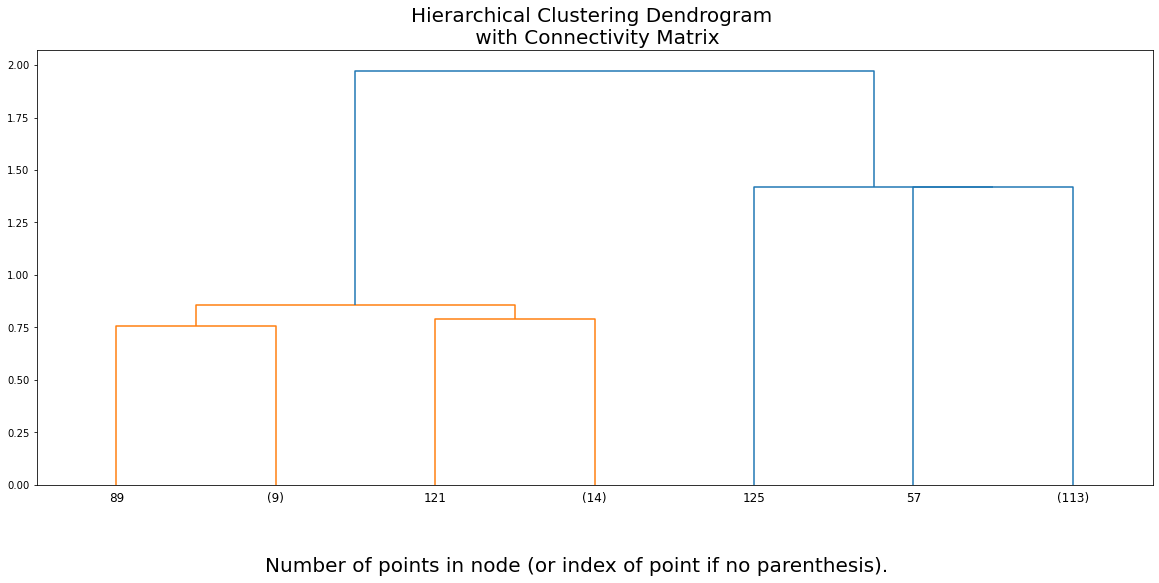

In [39]:
# Show dendrogram plot. Adjust p in 'dn1' to see different cluster numbers.
# when p = 2, we can just see n_clusters = 7, which is what I chose.
fig, ax = plt.subplots(figsize=(20,8)) # just one plot, but unpacked.
plt.title('Hierarchical Clustering Dendrogram \n with Connectivity Matrix', size=20)
dn1 = plot_dendrogram(model, truncate_mode='level', p=2, orientation = 'top')
fig.suptitle("Number of points in node (or index of point if no parenthesis).", y=0, size=20)
plt.show()

### Fit selected model
The silhouette score recommended ten clusters. The silhouette scores are close together and examining the dendrograms, ther is not much change between seven and ten clusters. (Note: adjust _p_ in the dendrogram plotting to see how the plots change). The next few code blocks fit the selected model.

In [40]:
## refit and retain labels
labels = AgglomerativeClustering(n_clusters=7, connectivity=connectivity).fit_predict(all_venues_grouped)
## Add the cluster labels onto the dataset and make index.
all_venues_grouped.insert(0, 'Cluster', labels)
all_venues_grouped.set_index('Cluster', append=True, inplace = True)
## Distribution of neighborhoods across clusters
all_venues_grouped = all_venues_grouped.reorder_levels(['Cluster','City','CODE'])
display(all_venues_grouped.groupby(["Cluster","City"]).size()) # looks good!

Cluster  City        
0        Philadelphia    44
         Toronto         66
1        Philadelphia     2
         Toronto         23
2        Toronto          1
3        Toronto          1
4        Toronto          1
5        Toronto          1
6        Toronto          1
dtype: int64

### Describe clusters with Foursquare results
Philadelphia's forty-six residential neighborhoods are spread across two clusters. Toronto's ninety-four residential neighborhoods are spread across nine clusters. The three clusters containing Philadelphia postal codes also contain Toronto postal codes. Four postal codes in Toronto were not combined with any other postal code. Looking at the data from Foursquare, let's try to describe these clusters by their popular venues.

Borrow the function to sort the venues in descending order and create a dataframe to display the top 10 venues for each cluster.

In [41]:
# Setup data to get top 10 venues by cluster rather than neighborhood.
df = all_venues_grouped.reset_index()[['Cluster','City','CODE']]
all_venues_onehot_clust = all_venues_onehot.merge(df, on=['City','CODE'])
all_venues_grouped_clust = all_venues_onehot_clust.groupby('Cluster').mean()
all_venues_grouped_clust.reset_index(inplace=True)

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cluster_venues_sorted = pd.DataFrame(columns=columns)
cluster_venues_sorted['Cluster'] = all_venues_grouped_clust['Cluster']

for ind in np.arange(all_venues_grouped_clust.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues(all_venues_grouped_clust.iloc[ind, :], num_top_venues)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(cluster_venues_sorted)


,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Coffee Shop,Pizza Place,Café,Italian Restaurant,Bakery,Bar,Sandwich Place,Restaurant,Pharmacy,Grocery Store
1,1,Park,Bakery,Convenience Store,Intersection,Trail,Coffee Shop,Gym,Brewery,Grocery Store,Gym / Fitness Center
2,2,Rental Service,Zoo Exhibit,Dry Cleaner,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop
3,3,Auto Garage,Zoo Exhibit,Eastern European Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Falafel Restaurant
4,4,Korean BBQ Restaurant,Zoo Exhibit,Eastern European Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Falafel Restaurant
5,5,Pool,Zoo Exhibit,Falafel Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop
6,6,Baseball Field,Zoo Exhibit,Farmers Market,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Fast Food Restaurant


The first cluster (cluster 0) contains 64 Toronto neighborhoods and 44 Philadelphia neighborhoods. This is by far the largest cluster in terms of number of neighborhoods it contains. Looking across its top ten venues, this cluster seems like an ideal residential cluster, with restaurants, bars and cafes, as well as a grocery store and pharmacy.

The second cluster (cluster 1) contains 23 Toronto neighborhoods and 2 Philadelphia neighborhoods. It seems like it might be a little less residential with fewer options neighborhood activities. However, parks and gyms figure more prominently in this cluster, suggesting it might be a better choice for someone who prefers more active recreational activities.

The remaining five clusters contain a single Toronto neighborhood each. These clusters all share a zoo exhibit and event space. From the Foursquare data, these Toronto neighborhoods do not look very residential. 

Let's visualize the results by cluster.

### Visualize clusters
The next few code blocks take advantage of geopandas to visualize the data. The two cities are far aprt geogrpaphically so it does not make must sense so show them on the same map. Instead, the two cities are shown side by side and neighborhoods in the same cluster are color coded the same for comparison.

In [26]:
# Combine the geopandas dataframes and add the cluster labels
all_bounds=pd.concat([philly_bounds, toronto_bounds])
all_venues_grouped.reset_index(inplace=True)
all_venues_grouped["CODE"] = all_venues_grouped["CODE"].astype('str')
all_venues_and_bounds = all_venues_grouped.merge(all_bounds, on='CODE')
all_venues_and_bounds_small = gpd.GeoDataFrame(all_venues_and_bounds[['Cluster','City','CODE','geometry']], crs="EPSG:4326", geometry="geometry")

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [28]:
# create color map including all clusters across both cities.
keys = list(all_venues_and_bounds_small['Cluster'].sort_values().unique())# cluster count = no. colors needed
color_range = list(np.linspace(0, 1, len(keys), endpoint=False)) # indices to step through colormap
colors = [cm.tab20b(x) for x in color_range] #tab20 is a good color map for qualitative data
color_dict = dict(zip(keys, colors)) # create color dictionary for BOTH maps

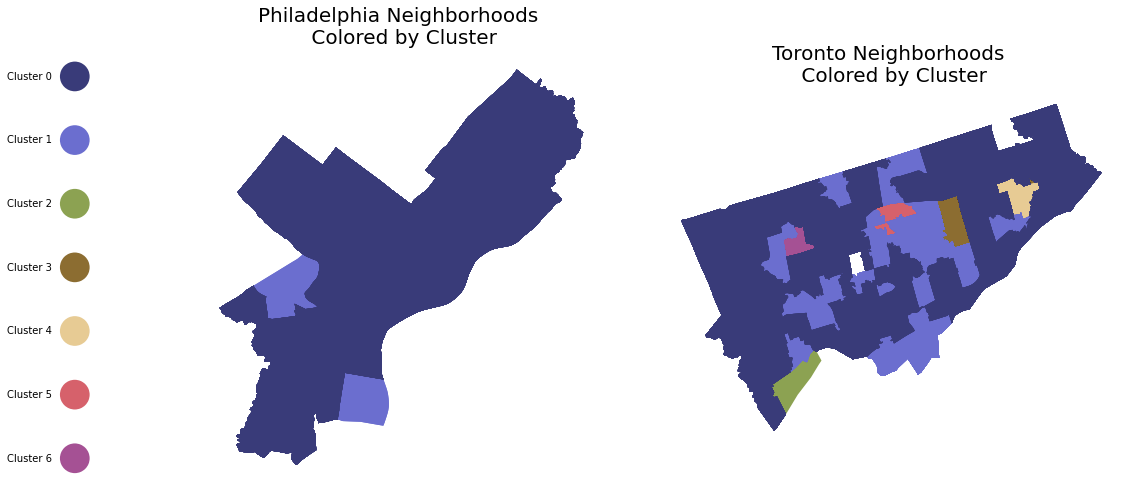

In [29]:
## Column 1 holds legend (i.e., color-coded cluster labels)
## Columns 2 through 4 will hold Philadelphia map.
## Columns 5 through 7 will hold Toronto map.
row_count = all_venues_and_bounds_small['Cluster'].nunique() # need a row for each cluster (for legend)
ax_list = []

for i in range(row_count+1):
    ax_list.append('ax' + str(i+1))
    ax_string = ', '.join(ax_list)
fig, (ax_string) = plt.subplots(row_count, 7, figsize = (20,8), sharey=True) # should make a row_count x 7 grid. looks good!

# separate data for philly and toronto
small_philly = all_venues_and_bounds_small[all_venues_and_bounds_small['City']=="Philadelphia"]
small_toronto = all_venues_and_bounds_small[all_venues_and_bounds_small['City']=="Toronto"]

# setup where Philly (ax1) and Toronto (ax2) will display 
ax1 = plt.subplot2grid((row_count, 7), (0,1), rowspan=row_count, colspan=3)
ax2 = plt.subplot2grid((row_count, 7), (0,4), rowspan=row_count, colspan=3)

# create the legend and send it to the first column of the plotting grid.
cluster_labels = []
for i in keys:
    cluster_labels.append("Cluster {}  ".format(i))
    
row_counter = 0
for i in keys: 
    plt.subplot2grid((row_count,7),(row_counter,0))
    plt.pie([1], labels = [cluster_labels[i]], radius=0.70, colors=[color_dict[i]])
    plt.axis('off')
    row_counter += 1

# create Philadelphia and send it to the next three columns of the plotting grid.
for index, row in small_philly.iterrows():
    plot1 = small_philly[small_philly['Cluster'] == row['Cluster']].plot(color=color_dict[row['Cluster']], ax=ax1)
ax1.set_title('Philadelphia Neighborhoods \n Colored by Cluster', size=20, loc='center')
ax1.axis('off')

# create Toronto and send it to the last three columns of the plotting grid.
for index, row in small_toronto.iterrows():
    plot2 = small_toronto[small_toronto['Cluster'] == row['Cluster']].plot(color=color_dict[row['Cluster']], ax=ax2)
ax2.set_title('Toronto Neighborhoods \n Colored by Cluster', size=20, loc='center')
ax2.axis('off')

plt.show()

### Associate neighborhood names with postal codes
Names for neighborhoods beyond their postal codes are helpful for interpretation of results.

In [30]:
# The names for Toronto neighborhoods are scraped scraped using pandas.
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df_url = pd.read_html(url) 
# We need the first table on the Wikipedia page. 
# Exclude entries where Borough is unassigned.
toronto_neigh = df_url[0][df_url[0].Borough != "Not assigned"].drop(["Borough"], axis = 1).reset_index(drop=True)

# The names for Philadelphia neighborhoods are retrieved from an Excel file I created using pandas.
philly_neigh = pd.read_excel("https://github.com/JaeAre/Coursera_Capstone/raw/main/Philly%20ZIP%20and%20Neighborhoods.xlsx")

# Standardize the feature names for convenience later.
philly_neigh.rename(columns={"Neighborhood":"Neighbourhood"}, inplace = True)
philly_neigh.rename(columns={"ZIP":"CODE"}, inplace = True)
philly_neigh["CODE"] = philly_neigh["CODE"].astype('str') # ZIP codes read in as numeric sometimes
toronto_neigh.rename(columns={"Postal Code":"CODE"}, inplace = True)

# put them together in one dataframe
all_neigh = pd.concat([philly_neigh, toronto_neigh])

# look at all 140 results sorted
pd.set_option('display.max_rows', all_neigh.shape[0])
display(all_venues_and_bounds_small.merge(all_neigh, how = 'left', on = 'CODE').drop(['geometry'], axis=1).sort_values(['Cluster','City','Neighbourhood']))

,Cluster,City,CODE,Neighbourhood
28,0,Philadelphia,19137,Bridesburg
8,0,Philadelphia,19116,Bustleton North and Somerton
7,0,Philadelphia,19115,Bustleton South
41,0,Philadelphia,19150,Cedarbrook
0,0,Philadelphia,19102,Center City
1,0,Philadelphia,19103,Center City West
9,0,Philadelphia,19118,Chestnut Hill
20,0,Philadelphia,19129,East Falls
44,0,Philadelphia,19153,Eastwick
12,0,Philadelphia,19121,Fairmount North and Brewerytown


## Recap
The purpose of this project was to cluster the neighborhoods of two cities, Toronto and Philadelphia, so that someone familiar with one city could better understand the neighborhoods in the other city. With more time, some additional avenues of exploration might be:

1. Expand the analysis to beyond two cities so that someone familiar with one city could choose one among many city's neighborhoods for relocation.
2. Incorporate data beyond those available from Foursquare (i.e., housing prices, crime, etc.)
3. Adjust the structure of the analysis (i.e., the connectivity matrix) so that results could be tailored to the reference city of the user.